# Forecast stock price via multiple methods using pycaret

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import os
import ipywidgets as widgets
import requests
import random
import time
import matplotlib.dates as mdates
import itertools

# Importing encoders
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Import for string manipulation
import nltk
import string
import re


# Time Series Imports
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pycaret.time_series import *
from sktime.forecasting.model_selection import SlidingWindowSplitter
from sklearn.model_selection import TimeSeriesSplit

# Model Evaluation Imports
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


# To increase the visible rows & cols
pd.options.display.max_rows = 2500
pd.options.display.max_columns = 15000

### Data Import: Importing stocks data that we will be predicting

These are the stocks that we will be forecasting:

r/wallstreetbets:
1. GME
2. AMC
3. TSLA
4. META

r/investing:
1. GM
2. UBER
3. RIOT
4. AMD

In [2]:
# import the 10 year historical data of each stock

# r/wallstreetbets
gme_test_df = pd.read_csv('../data/gme1_historical.csv')
gme_df = pd.read_csv('../data/gme_historical.csv')
amc_df = pd.read_csv('../data/amc_historical.csv')
tsla_df = pd.read_csv('../data/tsla_historical.csv')
meta_df = pd.read_csv('../data/meta_historical.csv')

# r/investing
gm_df = pd.read_csv('../data/gm_historical.csv')
uber_df = pd.read_csv('../data/uber_historical.csv')
riot_df = pd.read_csv('../data/riot_historical.csv')
amd_df = pd.read_csv('../data/amd_historical.csv')

In [3]:
# Comment seems like there are $ signs in the data  which we will need to remove later on

gme_df.head()

,Date,Close/Last,Volume,Open,High,Low
0,07/25/2023,$22.85,1671991,$23.10,$23.10,$22.53
1,07/24/2023,$23.04,2970433,$22.42,$23.04,$22.20
2,07/21/2023,$22.18,3167916,$23.05,$23.22,$22.16
3,07/20/2023,$22.91,2256659,$23.01,$23.22,$22.66
4,07/19/2023,$23.17,2250133,$23.42,$23.58,$22.96


In [4]:
gme_df.tail()

,Date,Close/Last,Volume,Open,High,Low
2511,08/01/2013,$12.495,16796516,$12.38,$12.84,$12.315
2512,07/31/2013,$12.265,18825016,$11.785,$12.38,$11.785
2513,07/30/2013,$11.7275,10822960,$11.3625,$11.8125,$11.36
2514,07/29/2013,$11.3475,7770952,$11.4175,$11.435,$11.1425
2515,07/26/2013,$11.45,10389824,$11.015,$11.4625,$10.9664


In [5]:
# Comment: There seems to be no null values here

gme_df.isnull().sum().sort_values(ascending = False)

Date          0
Close/Last    0
Volume        0
Open          0
High          0
Low           0
dtype: int64

In [6]:
# Doesnt seem to have any duplicated data either

print(gme_df[gme_df.duplicated()])

Empty DataFrame
Columns: [Date, Close/Last, Volume, Open, High, Low]
Index: []


In [7]:
# Will need to change the data type for price columns into float

gme_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2516 entries, 0 to 2515
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        2516 non-null   object
 1   Close/Last  2516 non-null   object
 2   Volume      2516 non-null   int64 
 3   Open        2516 non-null   object
 4   High        2516 non-null   object
 5   Low         2516 non-null   object
dtypes: int64(1), object(5)
memory usage: 118.1+ KB


In [8]:
# To remove the $ sign and change the datatypes into float

def clean_data(df):
    for col in ["Close/Last", "Open", "High", "Low"]:
        df[col] = df[col].str.replace("$", "").astype(float)

In [9]:
clean_data(gme_test_df)
gme_test_df.head()

,Date,Close/Last,Volume,Open,High,Low
0,07/25/2023,22.85,1671991,23.10,23.10,22.53
1,07/24/2023,23.04,2970433,22.42,23.04,22.20
2,07/21/2023,22.18,3167916,23.05,23.22,22.16
3,07/20/2023,22.91,2256659,23.01,23.22,22.66
4,07/19/2023,23.17,2250133,23.42,23.58,22.96


For the purpose of price prediction, we will use VWAP as the price of stock

VWAP is defined as: Volume Weighted Average Price, it is a trading benchmark that represents the average price a security traded at throughout the day, based on both volume and price.

- VWAP = (Cumulative typical price * Volume) / Culmulative Volume
- Where: Typical Price = (High Price + Low Price + Closing Price)/3

In [10]:
# Create a function that adds a new column "VWAP" to the dataframe

def calc_vwap(df):
    df["Typical_Price"] = (df["High"] + df["Low"] + df["Close/Last"])/3
    df["VWAP"] = (np.cumsum(df["Volume"] * df["Typical_Price"]) / np.cumsum(df["Volume"])).round(2)
    return df


In [11]:
# Generate VWAP which will be the price we will use in the time series prediction

calc_vwap(gme_test_df)

,Date,Close/Last,Volume,Open,High,Low,Typical_Price,VWAP
0,07/25/2023,22.8500,1671991,23.1000,23.1000,22.5300,22.826667,22.83
1,07/24/2023,23.0400,2970433,22.4200,23.0400,22.2000,22.760000,22.78
2,07/21/2023,22.1800,3167916,23.0500,23.2200,22.1600,22.520000,22.68
3,07/20/2023,22.9100,2256659,23.0100,23.2200,22.6600,22.930000,22.73
4,07/19/2023,23.1700,2250133,23.4200,23.5800,22.9600,23.236667,22.83
...,...,...,...,...,...,...,...,...
2511,08/01/2013,12.4950,16796516,12.3800,12.8400,12.3150,12.550000,16.17
2512,07/31/2013,12.2650,18825016,11.7850,12.3800,11.7850,12.143333,16.17
2513,07/30/2013,11.7275,10822960,11.3625,11.8125,11.3600,11.633333,16.17
2514,07/29/2013,11.3475,7770952,11.4175,11.4350,11.1425,11.308333,16.17


In [12]:
# Make a function that ensures that 'Date' is in datatime format
gme_test_df['Date'] = pd.to_datetime(gme_test_df['Date'])

# Set Date as the index for
gme_test_df.set_index("Date", inplace = True)

# Reset the order of the date so that it is from oldest to most recent to help the model to predict 
gme_test_df = gme_test_df.sort_index(ascending=True)

# From now we will only use VWAP to predict the price of the stock, so we shall remove other unnecessary columns
gme_test_df = gme_test_df[['VWAP']]

# Resets any prevailing indexes of the DataFrame, and use the default one instead
# gme_test_df = gme_test_df.reset_index()

<Axes: xlabel='Date'>

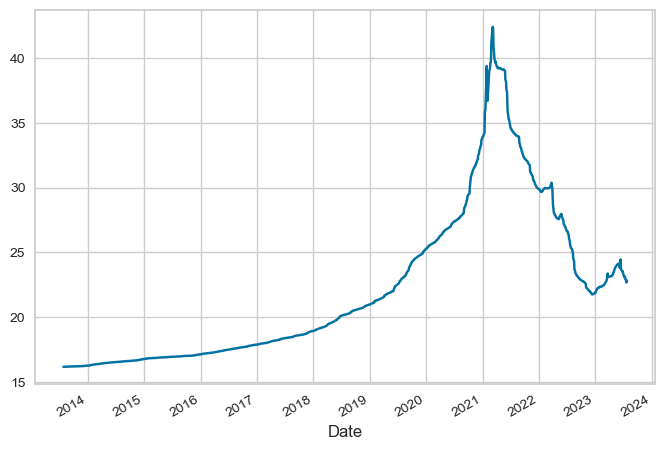

In [13]:
gme_test_df['VWAP'].plot()
# gme_test_df.set_index('Date').VWAP.plot()

### Building Multiple model using pycaret

In [14]:
gme_test_df.index

DatetimeIndex(['2013-07-26', '2013-07-29', '2013-07-30', '2013-07-31',
               '2013-08-01', '2013-08-02', '2013-08-05', '2013-08-06',
               '2013-08-07', '2013-08-08',
               ...
               '2023-07-12', '2023-07-13', '2023-07-14', '2023-07-17',
               '2023-07-18', '2023-07-19', '2023-07-20', '2023-07-21',
               '2023-07-24', '2023-07-25'],
              dtype='datetime64[ns]', name='Date', length=2516, freq=None)

In [15]:
idx = pd.date_range(start=min(gme_test_df.index), end=max(gme_test_df.index), freq='D')
idx

DatetimeIndex(['2013-07-26', '2013-07-27', '2013-07-28', '2013-07-29',
               '2013-07-30', '2013-07-31', '2013-08-01', '2013-08-02',
               '2013-08-03', '2013-08-04',
               ...
               '2023-07-16', '2023-07-17', '2023-07-18', '2023-07-19',
               '2023-07-20', '2023-07-21', '2023-07-22', '2023-07-23',
               '2023-07-24', '2023-07-25'],
              dtype='datetime64[ns]', length=3652, freq='D')

In [16]:
gme_test_df.index.symmetric_difference(idx)

DatetimeIndex(['2013-07-27', '2013-07-28', '2013-08-03', '2013-08-04',
               '2013-08-10', '2013-08-11', '2013-08-17', '2013-08-18',
               '2013-08-24', '2013-08-25',
               ...
               '2023-06-25', '2023-07-01', '2023-07-02', '2023-07-04',
               '2023-07-08', '2023-07-09', '2023-07-15', '2023-07-16',
               '2023-07-22', '2023-07-23'],
              dtype='datetime64[ns]', length=1136, freq=None)

In [17]:
gme_test_df = gme_test_df.reindex(idx)
gme_test_df.tail(25)

,VWAP
2023-07-01,NaN
2023-07-02,NaN
2023-07-03,23.26
2023-07-04,NaN
2023-07-05,23.18
2023-07-06,23.12
2023-07-07,23.12
2023-07-08,NaN
2023-07-09,NaN
2023-07-10,23.13


In [18]:
gme_test_df = gme_test_df.fillna(method = 'ffill')
gme_test_df.tail(10)

,VWAP
2023-07-16,22.93
2023-07-17,22.89
2023-07-18,22.88
2023-07-19,22.83
2023-07-20,22.73
2023-07-21,22.68
2023-07-22,22.68
2023-07-23,22.68
2023-07-24,22.78
2023-07-25,22.83


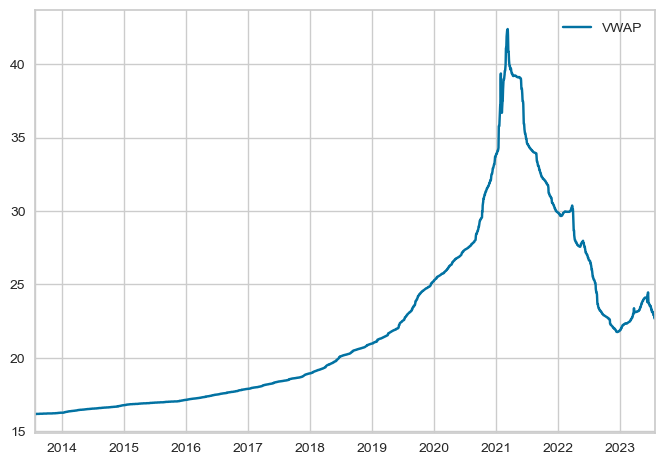

In [19]:
gme_test_df.plot()
plt.show()

## Time series Cross Validation with pycaret

In [20]:
ts = np.arange(10)
splitter = SlidingWindowSplitter(fh = np.arange(1,3), window_length= 3, step_length=1)
list(splitter.split(ts))

[(array([0, 1, 2], dtype=int64), array([3, 4], dtype=int64)),
 (array([1, 2, 3], dtype=int64), array([4, 5], dtype=int64)),
 (array([2, 3, 4], dtype=int64), array([5, 6], dtype=int64)),
 (array([3, 4, 5], dtype=int64), array([6, 7], dtype=int64)),
 (array([4, 5, 6], dtype=int64), array([7, 8], dtype=int64)),
 (array([5, 6, 7], dtype=int64), array([8, 9], dtype=int64))]

In [22]:
exp = TSForecastingExperiment()
exp.setup(data = gme_test_df, target = 'VWAP', coverage = 0.9, fold_strategy = SlidingWindowSplitter(fh = np.arange(1,23), window_length = 160, step_length = 160))

,Description,Value
0,session_id,697
1,Target,VWAP
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(3652, 1)"
5,Transformed data shape,"(3652, 1)"
6,Transformed train set shape,"(3630, 1)"
7,Transformed test set shape,"(22, 1)"
8,Rows with missing values,0.0%
9,Fold Generator,SlidingWindowSplitter


In [24]:
exp.plot_model(plot='train_test_split')

In [47]:
exp.compare_models(sort = 'R2')

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.2008,0.2386,0.1129,0.1492,0.0036,0.0037,-0.5464,0.1245
auto_arima,Auto ARIMA,0.1943,0.2245,0.1210,0.1582,0.0039,0.0040,-0.7044,8.4577
theta,Theta Forecaster,0.2810,0.3118,0.1977,0.2391,0.0064,0.0065,-2.4731,0.0105
naive,Naive Forecaster,0.3439,0.3930,0.2009,0.2411,0.0067,0.0067,-3.0028,0.3491
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,0.2497,0.2828,0.1479,0.1899,0.0050,0.0050,-3.0314,0.1214
exp_smooth,Exponential Smoothing,0.2640,0.2958,0.1484,0.1904,0.0051,0.0052,-3.7195,0.0273
dt_cds_dt,Decision Tree w/ Cond. Deseasonalize & Detrending,0.2607,0.2857,0.1820,0.2155,0.0061,0.0061,-4.1260,0.4991
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,0.2670,0.2933,0.1820,0.2171,0.0061,0.0062,-4.3782,0.1941
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,0.2547,0.2760,0.1834,0.2167,0.0062,0.0062,-4.4431,0.2068
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.2578,0.2813,0.1781,0.2121,0.0060,0.0060,-4.9045,0.1386


Processing:   0%|          | 0/121 [00:00<?, ?it/s]

BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [42, 41,
                                                                        40, 39,
                                                                        38, 37,
                                                                        36, 35,
                                                                        34, 33,
                                                                        32, 31,
                                                                        30, 29,
                                                                        28, 27,
                                                                        26, 25,
                                                                        24, 23,
                                                                        22, 21,
                                                                        20, 19,
                                                                        18, 17,
                                                                        16, 15,
                                                                        14, 13, ...]},
                                                   n_jobs=1)],
                    regressor=HuberRegressor(), sp=42, window_length=42)

Bootstrapping the selected models

In [23]:
my_models = ['huber_cds_dt', 'theta', 'naive', 'omp_cds_dt', 'exp_smooth', 'xgboost_cds_dt', 'arima', 'rf_cds_dt']
exp.compare_models(include = my_models, sort = 'R2')

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2,TT (Sec)
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.2008,0.2386,0.1129,0.1492,0.0036,0.0037,-0.5464,0.4991
theta,Theta Forecaster,0.2810,0.3118,0.1977,0.2391,0.0064,0.0065,-2.4731,0.0091
naive,Naive Forecaster,0.3439,0.3930,0.2009,0.2411,0.0067,0.0067,-3.0028,0.0068
omp_cds_dt,Orthogonal Matching Pursuit w/ Cond. Deseasonalize & Detrending,0.2497,0.2828,0.1479,0.1899,0.0050,0.0050,-3.0314,0.1214
exp_smooth,Exponential Smoothing,0.2640,0.2958,0.1484,0.1904,0.0051,0.0052,-3.7195,0.0223
rf_cds_dt,Random Forest w/ Cond. Deseasonalize & Detrending,0.2576,0.2784,0.1839,0.2175,0.0062,0.0062,-4.4525,0.2000
xgboost_cds_dt,Extreme Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.2602,0.2896,0.1768,0.2160,0.0060,0.0060,-5.1609,0.1318
arima,ARIMA,0.2896,0.3105,0.1953,0.2425,0.0065,0.0066,-8.0140,0.1223


Processing:   0%|          | 0/37 [00:00<?, ?it/s]

BaseCdsDtForecaster(fe_target_rr=[WindowSummarizer(lag_feature={'lag': [42, 41,
                                                                        40, 39,
                                                                        38, 37,
                                                                        36, 35,
                                                                        34, 33,
                                                                        32, 31,
                                                                        30, 29,
                                                                        28, 27,
                                                                        26, 25,
                                                                        24, 23,
                                                                        22, 21,
                                                                        20, 19,
                                                                        18, 17,
                                                                        16, 15,
                                                                        14, 13, ...]},
                                                   n_jobs=1)],
                    regressor=HuberRegressor(), sp=42, window_length=42)

Tuning the selected models

In [50]:
huber = exp.create_model('huber_cds_dt')

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2014-01-01,1.0138,1.2301,0.0229,0.0302,0.0014,0.0014,-1.6225
1,2014-06-10,0.0395,0.0456,0.0026,0.0031,0.0002,0.0002,0.8499
2,2014-11-17,0.4812,0.5570,0.0201,0.0234,0.0012,0.0012,-1.0403
3,2015-04-26,0.0979,0.1038,0.0053,0.0061,0.0003,0.0003,-0.7325
4,2015-10-03,0.0542,0.0719,0.0017,0.0024,0.0001,0.0001,0.6827
5,2016-03-11,0.0666,0.0847,0.0048,0.0062,0.0003,0.0003,0.7962
6,2016-08-18,0.0622,0.0767,0.0057,0.0071,0.0003,0.0003,0.8652
7,2017-01-25,0.0824,0.0917,0.0076,0.0085,0.0004,0.0004,0.4510
8,2017-07-04,0.0392,0.0489,0.0048,0.0061,0.0003,0.0003,0.7033
9,2017-12-11,0.4288,0.4876,0.0518,0.0620,0.0027,0.0027,-10.7629


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [52]:
# Huber with Condition Deseasonalize & Detrending

tuned_huber = exp.tune_model(huber)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2014-01-01,0.5881,0.7295,0.0133,0.0179,0.0008,0.0008,0.0777
1,2014-06-10,0.1098,0.1266,0.0073,0.0086,0.0004,0.0004,-0.1556
2,2014-11-17,0.4252,0.4911,0.0177,0.0206,0.0011,0.0011,-0.5856
3,2015-04-26,0.1041,0.1482,0.0057,0.0088,0.0003,0.0003,-2.5348
4,2015-10-03,0.0693,0.1026,0.0022,0.0034,0.0001,0.0001,0.3542
5,2016-03-11,0.1432,0.1554,0.0102,0.0114,0.0006,0.0006,0.3136
6,2016-08-18,0.0633,0.0747,0.0058,0.0069,0.0003,0.0003,0.8721
7,2017-01-25,0.0610,0.0776,0.0056,0.0072,0.0003,0.0003,0.6067
8,2017-07-04,0.1891,0.2095,0.0231,0.0260,0.0013,0.0013,-4.4502
9,2017-12-11,0.0647,0.0756,0.0078,0.0096,0.0004,0.0004,0.7172


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 22 folds for each of 10 candidates, totalling 220 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:   23.0s finished


In [25]:
theta1 = exp.create_model('theta')

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2014-01-01,0.8529,1.0092,0.0192,0.0248,0.0012,0.0012,-0.7653
1,2014-06-10,0.0384,0.0465,0.0025,0.0032,0.0002,0.0002,0.8439
2,2014-11-17,0.4528,0.5374,0.0189,0.0226,0.0011,0.0011,-0.8993
3,2015-04-26,0.0623,0.0686,0.0034,0.0041,0.0002,0.0002,0.2418
4,2015-10-03,0.1554,0.1794,0.0050,0.0059,0.0003,0.0003,-0.9753
5,2016-03-11,0.1645,0.2004,0.0118,0.0147,0.0007,0.0007,-0.1421
6,2016-08-18,0.1693,0.1976,0.0155,0.0182,0.0009,0.0009,0.1055
7,2017-01-25,0.0825,0.0965,0.0076,0.0090,0.0004,0.0004,0.3921
8,2017-07-04,0.0363,0.0472,0.0044,0.0059,0.0002,0.0002,0.7235
9,2017-12-11,0.2454,0.2521,0.0296,0.0321,0.0016,0.0016,-2.1460


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [26]:
# Theta Forecaster

tuned_theta1= exp.tune_model(theta1)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2014-01-01,0.8529,1.0092,0.0192,0.0248,0.0012,0.0012,-0.7653
1,2014-06-10,0.0384,0.0465,0.0025,0.0032,0.0002,0.0002,0.8439
2,2014-11-17,0.4528,0.5374,0.0189,0.0226,0.0011,0.0011,-0.8993
3,2015-04-26,0.0623,0.0686,0.0034,0.0041,0.0002,0.0002,0.2418
4,2015-10-03,0.1554,0.1794,0.0050,0.0059,0.0003,0.0003,-0.9753
5,2016-03-11,0.1645,0.2004,0.0118,0.0147,0.0007,0.0007,-0.1421
6,2016-08-18,0.1693,0.1976,0.0155,0.0182,0.0009,0.0009,0.1055
7,2017-01-25,0.0825,0.0965,0.0076,0.0090,0.0004,0.0004,0.3921
8,2017-07-04,0.0363,0.0472,0.0044,0.0059,0.0002,0.0002,0.7235
9,2017-12-11,0.2454,0.2521,0.0296,0.0321,0.0016,0.0016,-2.1460


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 22 folds for each of 2 candidates, totalling 44 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    0.2s finished


In [57]:
naive1 = exp.create_model('naive')

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2014-01-01,0.9477,1.1547,0.0214,0.0284,0.0013,0.0013,-1.3110
1,2014-06-10,0.1513,0.1889,0.0100,0.0128,0.0006,0.0006,-1.5714
2,2014-11-17,0.5669,0.6844,0.0236,0.0288,0.0014,0.0014,-2.0800
3,2015-04-26,0.0586,0.0955,0.0032,0.0056,0.0002,0.0002,-0.4667
4,2015-10-03,0.0706,0.1452,0.0023,0.0048,0.0001,0.0001,-0.2941
5,2016-03-11,0.2669,0.3204,0.0191,0.0235,0.0011,0.0011,-1.9174
6,2016-08-18,0.3718,0.4253,0.0341,0.0391,0.0019,0.0019,-3.1442
7,2017-01-25,0.1977,0.2310,0.0182,0.0215,0.0010,0.0010,-2.4845
8,2017-07-04,0.1787,0.1974,0.0218,0.0245,0.0012,0.0012,-3.8400
9,2017-12-11,0.3500,0.3616,0.0423,0.0460,0.0022,0.0022,-5.4706


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [58]:
# Naive Forecaster

tuned_naive1= exp.tune_model(naive1)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2014-01-01,0.7069,0.8658,0.0159,0.0213,0.0010,0.0010,-0.2991
1,2014-06-10,0.1332,0.1422,0.0088,0.0096,0.0005,0.0005,-0.4567
2,2014-11-17,0.3354,0.3796,0.0140,0.0160,0.0008,0.0008,0.0523
3,2015-04-26,0.2343,0.2362,0.0127,0.0140,0.0008,0.0008,-7.9780
4,2015-10-03,0.1989,0.2204,0.0064,0.0072,0.0004,0.0004,-1.9821
5,2016-03-11,0.0614,0.0757,0.0044,0.0056,0.0003,0.0003,0.8373
6,2016-08-18,0.1150,0.1390,0.0105,0.0128,0.0006,0.0006,0.5575
7,2017-01-25,0.0854,0.0972,0.0079,0.0091,0.0004,0.0004,0.3832
8,2017-07-04,0.0808,0.0939,0.0099,0.0117,0.0005,0.0005,-0.0949
9,2017-12-11,0.0614,0.0674,0.0074,0.0086,0.0004,0.0004,0.7753


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 22 folds for each of 2 candidates, totalling 44 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  44 out of  44 | elapsed:    0.1s finished


In [59]:
omp = exp.create_model('omp_cds_dt')

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2014-01-01,0.8225,1.0274,0.0185,0.0252,0.0011,0.0011,-0.8295
1,2014-06-10,0.0396,0.0482,0.0026,0.0033,0.0002,0.0002,0.8323
2,2014-11-17,0.4103,0.4742,0.0171,0.0199,0.0010,0.0010,-0.4784
3,2015-04-26,0.2721,0.2647,0.0148,0.0156,0.0009,0.0009,-10.2755
4,2015-10-03,0.0591,0.0897,0.0019,0.0029,0.0001,0.0001,0.5063
5,2016-03-11,0.0485,0.0575,0.0035,0.0042,0.0002,0.0002,0.9062
6,2016-08-18,0.0709,0.0893,0.0065,0.0082,0.0004,0.0004,0.8172
7,2017-01-25,0.0640,0.0789,0.0059,0.0074,0.0003,0.0003,0.5938
8,2017-07-04,0.0473,0.0602,0.0058,0.0075,0.0003,0.0003,0.5498
9,2017-12-11,0.4136,0.4576,0.0500,0.0582,0.0026,0.0026,-9.3632


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [60]:
# Orthogonal Matching Pursuit with Condition, Deseasonalize and Detrending

tuned_omp= exp.tune_model(omp)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2014-01-01,0.5621,0.6975,0.0127,0.0171,0.0008,0.0008,0.1569
1,2014-06-10,0.1033,0.1210,0.0068,0.0082,0.0004,0.0004,-0.0553
2,2014-11-17,0.4030,0.4742,0.0168,0.0199,0.0010,0.0010,-0.4788
3,2015-04-26,0.1886,0.2102,0.0102,0.0124,0.0006,0.0006,-6.1088
4,2015-10-03,0.1048,0.1352,0.0034,0.0044,0.0002,0.0002,-0.1228
5,2016-03-11,0.1979,0.2052,0.0142,0.0151,0.0008,0.0008,-0.1970
6,2016-08-18,0.0711,0.0797,0.0065,0.0073,0.0004,0.0004,0.8546
7,2017-01-25,0.0416,0.0506,0.0038,0.0047,0.0002,0.0002,0.8328
8,2017-07-04,0.2137,0.2395,0.0261,0.0297,0.0014,0.0014,-6.1199
9,2017-12-11,0.0604,0.0725,0.0073,0.0092,0.0004,0.0004,0.7399


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 22 folds for each of 10 candidates, totalling 220 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   18.1s
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:   23.4s finished


In [62]:
smooth = exp.create_model('exp_smooth')

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2014-01-01,0.8241,0.9461,0.0186,0.0232,0.0011,0.0011,-0.5513
1,2014-06-10,0.0578,0.0699,0.0038,0.0047,0.0002,0.0002,0.6480
2,2014-11-17,0.3838,0.4469,0.0160,0.0188,0.0010,0.0010,-0.3134
3,2015-04-26,0.1463,0.1452,0.0079,0.0086,0.0005,0.0005,-2.3946
4,2015-10-03,0.1937,0.2091,0.0062,0.0069,0.0004,0.0004,-1.6833
5,2016-03-11,0.0587,0.0802,0.0042,0.0059,0.0002,0.0002,0.8172
6,2016-08-18,0.0770,0.0896,0.0071,0.0082,0.0004,0.0004,0.8159
7,2017-01-25,0.1094,0.1171,0.0101,0.0109,0.0006,0.0006,0.1052
8,2017-07-04,0.1662,0.1767,0.0203,0.0219,0.0011,0.0011,-2.8757
9,2017-12-11,0.1204,0.1640,0.0145,0.0208,0.0008,0.0008,-0.3307


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [64]:
# Exponential smooth

tuned_smooth= exp.tune_model(smooth)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2014-01-01,nan,nan,nan,nan,nan,nan,nan
1,2014-06-10,nan,nan,nan,nan,nan,nan,nan
2,2014-11-17,nan,nan,nan,nan,nan,nan,nan
3,2015-04-26,nan,nan,nan,nan,nan,nan,nan
4,2015-10-03,nan,nan,nan,nan,nan,nan,nan
5,2016-03-11,nan,nan,nan,nan,nan,nan,nan
6,2016-08-18,nan,nan,nan,nan,nan,nan,nan
7,2017-01-25,nan,nan,nan,nan,nan,nan,nan
8,2017-07-04,nan,nan,nan,nan,nan,nan,nan
9,2017-12-11,nan,nan,nan,nan,nan,nan,nan


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 22 folds for each of 10 candidates, totalling 220 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 189 out of 220 | elapsed:    1.7s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:    1.9s finished


In [65]:
xgboost = exp.create_model('xgboost_cds_dt')

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2014-01-01,0.7221,0.8867,0.0163,0.0218,0.0010,0.0010,-0.3626
1,2014-06-10,0.0628,0.0770,0.0041,0.0052,0.0003,0.0003,0.5731
2,2014-11-17,0.4096,0.4882,0.0171,0.0205,0.0010,0.0010,-0.5674
3,2015-04-26,0.2162,0.2261,0.0117,0.0134,0.0007,0.0007,-7.2280
4,2015-10-03,0.0671,0.0874,0.0022,0.0029,0.0001,0.0001,0.5313
5,2016-03-11,0.0516,0.0645,0.0037,0.0047,0.0002,0.0002,0.8819
6,2016-08-18,0.0869,0.1049,0.0080,0.0097,0.0005,0.0005,0.7476
7,2017-01-25,0.0455,0.0586,0.0042,0.0055,0.0002,0.0002,0.7762
8,2017-07-04,0.0493,0.0595,0.0060,0.0074,0.0003,0.0003,0.5606
9,2017-12-11,0.2667,0.2947,0.0322,0.0375,0.0017,0.0017,-3.2980


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [66]:
# Extreme gradient boosting with condition, deseasonalize and detrending

tuned_xgboost= exp.tune_model(xgboost)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2014-01-01,0.5288,0.5427,0.0119,0.0133,0.0007,0.0007,0.4896
1,2014-06-10,0.0497,0.0573,0.0033,0.0039,0.0002,0.0002,0.7636
2,2014-11-17,0.3016,0.3283,0.0126,0.0138,0.0008,0.0008,0.2911
3,2015-04-26,0.0872,0.1140,0.0047,0.0067,0.0003,0.0003,-1.0924
4,2015-10-03,0.3169,0.3290,0.0102,0.0108,0.0006,0.0006,-5.6440
5,2016-03-11,0.3787,0.3758,0.0271,0.0276,0.0016,0.0016,-3.0143
6,2016-08-18,0.0991,0.1251,0.0091,0.0115,0.0005,0.0005,0.6416
7,2017-01-25,0.1164,0.1268,0.0107,0.0118,0.0006,0.0006,-0.0497
8,2017-07-04,0.3698,0.3839,0.0452,0.0476,0.0025,0.0024,-17.3029
9,2017-12-11,0.0800,0.0996,0.0097,0.0127,0.0005,0.0005,0.5088


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 22 folds for each of 10 candidates, totalling 220 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:   25.4s finished


In [67]:
arima1 = exp.create_model('arima')

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2014-01-01,0.6632,0.7473,0.0149,0.0184,0.0009,0.0009,0.0322
1,2014-06-10,0.1274,0.1371,0.0084,0.0093,0.0005,0.0005,-0.3539
2,2014-11-17,0.4048,0.4568,0.0169,0.0192,0.0010,0.0010,-0.3722
3,2015-04-26,0.2360,0.2527,0.0128,0.0149,0.0008,0.0008,-9.2715
4,2015-10-03,0.1873,0.2283,0.0060,0.0075,0.0004,0.0004,-2.1980
5,2016-03-11,0.0695,0.0805,0.0050,0.0059,0.0003,0.0003,0.8159
6,2016-08-18,0.0612,0.0759,0.0056,0.0070,0.0003,0.0003,0.8679
7,2017-01-25,0.0668,0.0681,0.0061,0.0063,0.0003,0.0003,0.6971
8,2017-07-04,0.2289,0.2538,0.0280,0.0315,0.0015,0.0015,-6.9964
9,2017-12-11,0.1675,0.1718,0.0202,0.0218,0.0011,0.0011,-0.4601


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [68]:
# ARIMA

tuned_arima1= exp.tune_model(arima1)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2014-01-01,0.9477,1.1547,0.0214,0.0284,0.0013,0.0013,-1.3110
1,2014-06-10,0.1948,0.2143,0.0129,0.0145,0.0008,0.0008,-2.3097
2,2014-11-17,0.4252,0.5149,0.0177,0.0216,0.0011,0.0011,-0.7430
3,2015-04-26,0.1767,0.1791,0.0096,0.0106,0.0006,0.0006,-4.1605
4,2015-10-03,0.2388,0.2661,0.0077,0.0087,0.0005,0.0005,-3.3448
5,2016-03-11,0.0593,0.0974,0.0042,0.0072,0.0002,0.0002,0.7306
6,2016-08-18,0.1233,0.1551,0.0113,0.0143,0.0006,0.0006,0.4488
7,2017-01-25,0.2547,0.2569,0.0234,0.0239,0.0013,0.0013,-3.3079
8,2017-07-04,0.0482,0.0612,0.0059,0.0076,0.0003,0.0003,0.5349
9,2017-12-11,0.1807,0.1867,0.0218,0.0237,0.0012,0.0012,-0.7254


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 22 folds for each of 10 candidates, totalling 220 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:  8.2min finished


In [69]:
rf = exp.create_model('rf_cds_dt')

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2014-01-01,0.6847,0.8535,0.0154,0.0210,0.0009,0.0009,-0.2627
1,2014-06-10,0.0646,0.0820,0.0043,0.0055,0.0003,0.0003,0.5160
2,2014-11-17,0.4111,0.4923,0.0171,0.0207,0.0010,0.0010,-0.5935
3,2015-04-26,0.1958,0.1975,0.0106,0.0117,0.0006,0.0006,-5.2732
4,2015-10-03,0.0506,0.1029,0.0016,0.0034,0.0001,0.0001,0.3504
5,2016-03-11,0.0423,0.0581,0.0030,0.0043,0.0002,0.0002,0.9042
6,2016-08-18,0.0533,0.0713,0.0049,0.0066,0.0003,0.0003,0.8835
7,2017-01-25,0.0482,0.0599,0.0044,0.0056,0.0002,0.0002,0.7656
8,2017-07-04,0.0669,0.0741,0.0082,0.0092,0.0004,0.0004,0.3185
9,2017-12-11,0.2160,0.2368,0.0261,0.0301,0.0014,0.0014,-1.7751


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [70]:
# Random Forest with Condition, Desasonalized and Detrending

tuned_rf= exp.tune_model(rf)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2014-01-01,0.5706,0.7034,0.0129,0.0173,0.0008,0.0008,0.1424
1,2014-06-10,0.1092,0.1197,0.0072,0.0081,0.0004,0.0004,-0.0333
2,2014-11-17,0.4115,0.4773,0.0172,0.0201,0.0010,0.0010,-0.4980
3,2015-04-26,0.2645,0.2566,0.0144,0.0152,0.0008,0.0009,-9.5927
4,2015-10-03,0.1070,0.1329,0.0034,0.0044,0.0002,0.0002,-0.0844
5,2016-03-11,0.2394,0.2386,0.0171,0.0175,0.0010,0.0010,-0.6186
6,2016-08-18,0.0766,0.0846,0.0070,0.0078,0.0004,0.0004,0.8359
7,2017-01-25,0.0434,0.0517,0.0040,0.0048,0.0002,0.0002,0.8255
8,2017-07-04,0.2569,0.2678,0.0314,0.0332,0.0017,0.0017,-7.9045
9,2017-12-11,0.1689,0.1785,0.0204,0.0227,0.0011,0.0011,-0.5758


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 22 folds for each of 10 candidates, totalling 220 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done 220 out of 220 | elapsed:   39.2s finished


tuned_theta1 is the best performer

In [27]:
tuned_theta1

ThetaForecaster(sp=42)

In [32]:
exp.plot_model(estimator = tuned_theta1, plot = "diagnostics")

In [34]:
exp.plot_model(tuned_theta1, plot = 'insample')

In [36]:
exp.plot_model(tuned_theta1, plot = 'forecast', data_kwargs = {'fh': 760})

## Predict Model

In [37]:
holdout_pred = exp.predict_model(tuned_theta1)

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,Theta Forecaster,0.5887,0.3637,0.3162,0.3690,0.0138,0.0137,-3.4126


In [38]:
holdout_pred

,y_pred
2023-07-04,23.2566
2023-07-05,23.2524
2023-07-06,23.2538
2023-07-07,23.2552
2023-07-08,23.2549
2023-07-09,23.2547
2023-07-10,23.2558
2023-07-11,23.2546
2023-07-12,23.2565
2023-07-13,23.2611


## Finalize Model

In [39]:
final_model = exp.finalize_model(tuned_theta1)

In [41]:
exp.plot_model(final_model, plot = 'forecast', data_kwargs = {'fh' : 760})

In [43]:
unseen_predictions = exp.predict_model(final_model, fh = 10)
unseen_predictions

,y_pred
2023-07-26,22.8340
2023-07-27,22.8430
2023-07-28,22.8522
2023-07-29,22.8521
2023-07-30,22.8521
2023-07-31,22.8587
2023-08-01,22.8657
2023-08-02,22.8735
2023-08-03,22.8772
2023-08-04,22.8821


### Conclusion: Model performance are unacceptable, will not be using any models from here